# Preparing data for ML; linear model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [17]:
# For ASCII plots of training progress
import asciichartpy
from IPython.display import clear_output

# Read data

In [2]:
# read data
path = Path("data/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

# some cleaning
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

# Preparing data for ML models

Our goal will be to forecast tomorrow’s ridership based
on the ridership of the past 8 weeks of data (56 days). The inputs to our model are sequences each containing 56 values from time steps $t – 55$ to $t$. For each input sequence, the model will output a single value: the forecast for time step $t + 1$.

## Split into training, validation and test

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [3]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

Blue is training, orange if validation, green is test

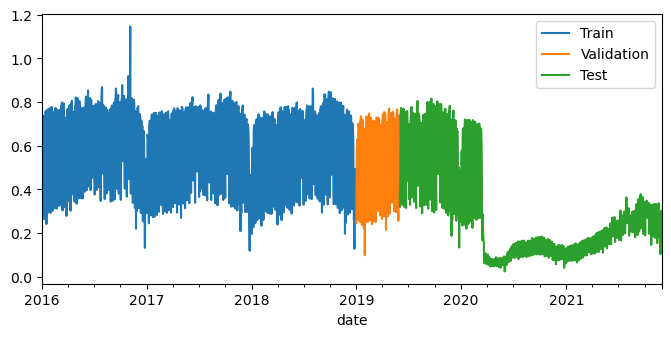

In [8]:
rail_train.plot(figsize=(8, 3.5), label='Train')
rail_valid.plot(label='Validation')
rail_test.plot(label='Test')
plt.legend()

Next, let’s create datasets for training and validation. Since gradient descent expects the instances in the training set to be independent and identically distributed (IID), we must set the argument `shuffle=True` to shuffle the training windows (*important*: not their contents).

Code below is equivalent to `tf.keras.utils.timeseries_dataset_from_array`

In [ ]:
# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        # Get sequence
        sequence = self.data[idx:idx+self.seq_length]
        # Get target (next value after sequence)
        target = self.data[idx+self.seq_length]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [11]:
# Convert rail_train to numpy array
data_array = rail_train.to_numpy()

# Create dataset
seq_length = 56
dataset = TimeSeriesDataset(data_array, seq_length)

# For reproducibility when shuffling
g = torch.Generator()
g.manual_seed(42)

# Create dataloader with shuffling and batching (train_ds)
train_loader = DataLoader(
    dataset, 
    batch_size=32, 
    shuffle=True,
    generator=g,
    drop_last=False
)

In [12]:
# Create validation dataset using the same TimeSeriesDataset class
valid_data_array = rail_valid.to_numpy()
valid_dataset = TimeSeriesDataset(valid_data_array, seq_length)

# Create validation dataloader (no shuffling needed for validation) (valid_ds)
valid_loader = DataLoader(
    valid_dataset, 
    batch_size=32, 
    shuffle=False,
    drop_last=False
)

# Linear model

This code defines a very simple neural network with:

- **1 input layer**: The input layer expects vectors of size `seq_length`.
- **1 dense (fully connected) layer**: This layer produces a single scalar value as output, which is a linear combination of the input values plus a bias, followed by an optional activation function (default is `none`, so it’s linear).

If the input to the `Dense` layer is a vector **`x`** of size `seq_length`, the output is computed as $y = xW + b$ where:
- **`x`**: Input vector of shape `(seq_length,)`.
- **`W`**: Weight matrix of shape `(seq_length, 1)`, learned during training.
- **`b`**: Bias term of shape `(1,)`, also learned during training.
- **`y`**: Output scalar value of shape `(1,)`.

This type of model is typically used for **very simple tasks**, such as:
1. **Linear regression**: Predicting a continuous value from the input.
2. **Binary classification**: If paired with an activation function like `sigmoid`, the output could represent the probability of a binary class.

Key differences between TensorFlow and PyTorch implementations:

1. PyTorch requires explicit definition of the training loop rather than using a `.fit()` method
2. Early stopping needs to be implemented manually instead of using callbacks
3. Loss and metric tracking is done manually during the training loop
4. PyTorch model definition uses a class-based approach with forward method
5. The `.squeeze()` method ensures the output dimensions match the targets for proper loss calculation

In [35]:
# Model definition
class SimpleForecaster(nn.Module):
    def __init__(self, seq_length):
        super(SimpleForecaster, self).__init__()
        self.linear = nn.Linear(seq_length, 1)
        
    def forward(self, x):
        return self.linear(x)

In [36]:
# Initialize model
model = SimpleForecaster(seq_length)

# Set up loss function (Huber loss equivalent in PyTorch is SmoothL1Loss)
criterion = nn.SmoothL1Loss()

# Set up optimizer with same parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

# Training setup
device = (torch.device('cuda') if torch.cuda.is_available() 
          else torch.device('mps') if torch.backends.mps.is_available() 
          else torch.device('cpu'))
model.to(device)
best_val_mae = float('inf')
patience_counter = 0
patience = 50
best_model_state = None

# dict with loss and MAE
history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}

## Training

Training loop with early stopping

In [37]:
for epoch in range(500):
    # Training phase
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item()
        mae = torch.mean(torch.abs(outputs - targets))
        train_mae += mae.item()
    
    train_loss /= len(train_loader)
    train_mae /= len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            
            # Calculate loss
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # Calculate MAE
            mae = torch.mean(torch.abs(outputs - targets))
            val_mae += mae.item()
    
    val_loss /= len(valid_loader)
    val_mae /= len(valid_loader)
    
    # Store history
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    
    #print(f'Epoch {epoch+1}/500, Loss: {train_loss:.4f}, MAE: {train_mae:.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}')
    #lossList.append(np.log10(float(loss)))
    clear_output(wait=True)
    print("              Epoch", epoch, ", Loss",round(float(train_loss),4))
    print(asciichartpy.plot(np.log10(history['loss']), {'height': 10}))
    
    # Early stopping logic
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

# Restore best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)

              Epoch 99 , Loss 0.0029
   -1.58  ┼╮
   -1.67  ┤│
   -1.77  ┤│
   -1.86  ┤│
   -1.95  ┤│
   -2.04  ┤│
   -2.14  ┤│
   -2.23  ┤╰╮
   -2.32  ┤ ╰──╮╭╮      ╭╮
   -2.42  ┤    ╰╯╰──────╯╰─╮ ╭──╮ ╭╮  ╭╮╭─╮                                     ╭╮
   -2.51  ┤                ╰─╯  ╰─╯╰──╯╰╯ ╰─────────────────────────────────────╯╰────────────────────────────
   -2.60  ┤
Early stopping triggered after 100 epochs


## Evaluation

The code below is equivalent to TF's

    valid_loss, valid_mae = model.evaluate(valid_ds)

This is a reusable method.

In [40]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            
            # Calculate loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            # Calculate MAE
            mae = torch.mean(torch.abs(outputs - targets))
            total_mae += mae.item()
    
    # Calculate average metrics
    avg_loss = total_loss / len(dataloader)
    avg_mae = total_mae / len(dataloader)
    
    return avg_loss, avg_mae

In [41]:
# Evaluate the model
valid_loss, valid_mae = evaluate_model(model, valid_loader, criterion, device)

# Scale MAE by 1e6 (same as in your TensorFlow code)
scaled_mae = valid_mae * 1e6

print(f"Validation Loss: {valid_loss:.4f}")
print(f"Validation MAE: {valid_mae:.4f}")
print(f"Scaled MAE (×1e6): {scaled_mae:.4f}")

Validation Loss: 0.0022
Validation MAE: 0.0378
Scaled MAE (×1e6): 37849.2624


Better than naive forecasting, worse than SARIMA.

# Forecasting whole TS

## A) predict one point at a time

For every prediction, uses the observations. No cumulative error involved.

In [42]:
ts_val=rail_valid.to_numpy()

In [43]:
y_preds = []
t = []
for i, today in enumerate(ts_val[seq_length+1:]):
    # Input array that will be used to compute the forecast
    t_in = torch.tensor(ts_val[i:seq_length+i], dtype=torch.float32).unsqueeze(0).to(device)
    
    # Disable gradient computation for inference
    with torch.no_grad():
        y_pred = model(t_in)
    
    # Extract the prediction value and add to list
    y_preds.append(y_pred.cpu().numpy().item())
    # put timestamp manually (slow) to make sure we are getting things right
    t.append(rail_valid.index[seq_length+1+i]) 

In [44]:
# convert to pandas series
y_predsP = pd.Series(y_preds, index=t)
# this is the alternate way of getting the time stamps, with less code
#y_predsP = pd.Series(y_preds, index=pd.date_range(rail_valid.index[seq_length+1], rail_valid.index[-1]))

mae1 = (y_preds - rail_valid[t]).abs().mean()*1e6

In [45]:
mae1

132810.60552237893

Displays the forecasts

Text(0.5, 1.0, 'Linear forecast A')

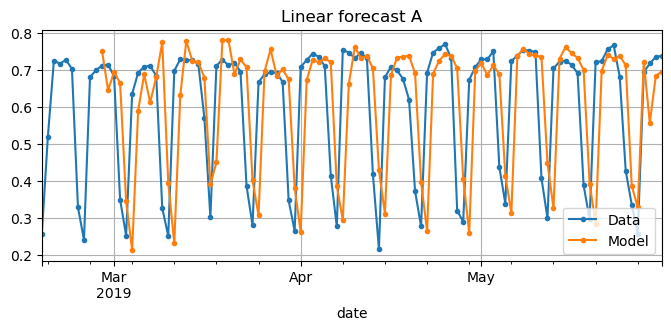

In [49]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_predsP.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_predsP, marker=".", label="Model")
plt.legend(fontsize=10, loc='lower right')
plt.title('Linear forecast A')

## B) whole future is unknown

We start with a given point, and from there we predict the future one step at a time. I expect considerable drifting as time advances.

In [50]:
y_preds = []
t = []
# Input array that will be used to compute the forecast
# Initialize the sliding window
t_in = ts_val[0:seq_length]

for i, today in enumerate(ts_val[seq_length+1:]):
    # Convert to PyTorch tensor and add batch dimension
    t_in_torch = torch.tensor(t_in, dtype=torch.float32).unsqueeze(0).to(device)
    
    # Make prediction without computing gradients
    with torch.no_grad():
        y_pred = model(t_in_torch)
    
    # Extract the prediction value
    y_pred_value = y_pred.cpu().numpy().item()
    y_preds.append(y_pred_value)
    
    # Record the timestamp
    t.append(rail_valid.index[seq_length+1+i]) 

    # Update the sliding window:
    # Shift all values one position left and add new prediction at the end
    t_in = np.roll(t_in, -1)
    t_in[-1] = y_pred_value

In [51]:
# convert to pandas series
y_predsP = pd.Series(y_preds, index=t)

mae2 = (y_preds - rail_valid[t]).abs().mean()*1e6

In [52]:
mae2

134252.4172635585

Displays the forecasts

Text(0.5, 1.0, 'Linear forecast B')

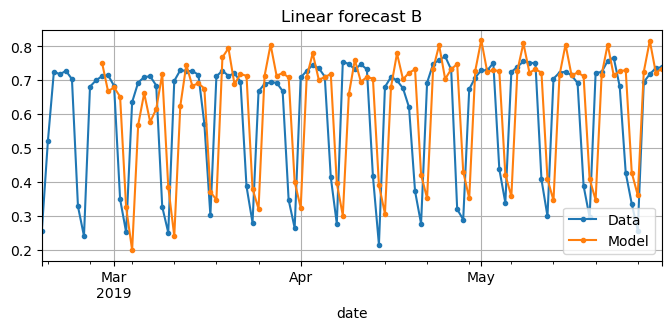

In [53]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_predsP.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_predsP, marker=".", label="Model")
plt.legend(fontsize=10, loc='lower right')
plt.title('Linear forecast B')

## Conclusions

**Abysmal performance at troughs** 

I suspect that when starting the forecast at a given time, the model does not know at what point in the period it began. It learned the seasonality, but is helpless about what to do at a random starting time. So I suspect that if we initialize the forecast precisely at the start of the week, the MAE will hugely improve.

**Same forecast with the two techniques**

It does not matter much whether we forecast using the actual data, one point at a time, or whether we start with the 56 first observations and from there let the model run by itself.